# Analytics of ML Features Usage in IDEs

Created by Yevhen Skyba, 2025


## Problem Definition

Your task is to analyze user activity data aggregated over a three-month period (March 2025 to May 2025). The dataset focuses on how users interact with different large language models, features, and license types in the context of IDE usage. It contains anonymized user-level and activity-level information, including requests and spending.

The goal of this task is to extract meaningful insights by exploring the dataset, understanding user behavior, identifying patterns, comparing models and features and proposing recommendations based on findings.

* `uuid` – user id
* `day_id` – day of the user activity (data is daily aggregated)
* `license` – user licence type
* `model` – used LLM type
* `feature` – used functionality type
* `requests_cnt` – number of requests done within the day
* `spent_amount` – amount of units (credits) spent within the day

## Setup

Note: Interactive plots may not render properly in PDF exports or notebook previews.
For the best experience and full interactivity, run the notebook in your environment (local IDE or Colab).

This notebook requires the following Python packages:
- pandas
- numpy
- matplotlib
- seaborn
- plotly

If running locally, install them via:
`pip install -r requirements.txt`

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Data Collection

In this stage, the dataset is loaded for analysis

**Loading the Dataset**

This notebook supports both **local environments** (e.g., PyCharm) and **Google Colab**. Depending on where you run the notebook, you should use one approach and comment out the other.

In [319]:
# For local use
try:
    df_orig = pd.read_csv('data/da_internship_task_dataset.csv')
except FileNotFoundError:
    print("Local file not found. Please upload the dataset.")

# If using Google Colab
# from google.colab import files
# uploaded = files.upload()
# import io
# df_orig = pd.read_csv(io.BytesIO(uploaded['da_internship_task_dataset.csv']))

In [320]:
print('Basic information about dataset:')
df_orig.info()

Basic information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          122746 non-null  object 
 1   day_id        122746 non-null  object 
 2   license       122746 non-null  object 
 3   model         122746 non-null  object 
 4   feature       122746 non-null  object 
 5   requests_cnt  122746 non-null  float64
 6   spent_amount  122746 non-null  float64
dtypes: float64(2), object(5)
memory usage: 6.6+ MB


The `day_id` column currently has an object data type. It will be converted to datetime during the preprocessing stage.

In [321]:
print('First few rows of the dataset:')
df_orig.head()

First few rows of the dataset:


,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88


After the brief preview of our dataset, I've noticed that example data off `requests_cnt` column has no decimal part, which would be checked.

## Preprocessing

The next stage is data cleaning. First, we create a copy of the dataset to preserve the original data. This ensures we can revisit or modify it if needed.

In [322]:
df = df_orig.copy()

We also check for missing values, since missing data can distort analysis. Verifying completeness ensures data quality before further processing.

In [323]:
df.isna().sum()

uuid            0
day_id          0
license         0
model           0
feature         0
requests_cnt    0
spent_amount    0
dtype: int64

All columns have 0 missing values, indicating the dataset is complete. Initially, calculating the percentage of missing data was considered, but it was deemed unnecessary in this case.

Next, we perform basic sanity checks on the numeric columns:

- `requests_cnt` should be an integer and non-negative.
- `spent_amount` should be non-negative.

And examine the number of unique values in the categorical columns:

- `license`
- `model`
- `feature`


In [324]:
has_decimals = (df['requests_cnt'] % 1 != 0).any()
has_negative_requests = (df['requests_cnt'] < 0).any()
has_negative_spent = (df['spent_amount'] < 0).any()

has_decimals, has_negative_requests, has_negative_spent

(np.False_, np.False_, np.False_)

All checks passed: `requests_cnt` contains no decimals or negative values, and `spent_amount` contains no negative values.

In [325]:
for col in ['license', 'model', 'feature']:
    print(f"Column '{col}' has {df[col].nunique()} unique categories:")
    print(f"  {sorted(df[col].unique())}\n")


Column 'license' has 4 unique categories:
  ['Basic', 'Enterprise', 'Premium', 'Standard']

Column 'model' has 5 unique categories:
  ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E']

Column 'feature' has 5 unique categories:
  ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']



The columns `license`, `model`, and `feature` contain a limited number of unique values and represent categorical data.

Next, we perform data type conversions to prepare the dataset for analysis:
* the `day_id` column was converted from `object` to `datetime` type to enable time-based analysis
* the `requests_cnt` column was converted to `integer` type
* the `license`, `model`, and `feature` columns were converted from `object` to `category` type to improve memory usage and signal that these columns represent categories

In [326]:
categorical_cols = ['license', 'model', 'feature']
df[categorical_cols] = df[categorical_cols].astype('category')

df['day_id'] = pd.to_datetime(df['day_id'])
df['requests_cnt'] = df['requests_cnt'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   uuid          122746 non-null  object        
 1   day_id        122746 non-null  datetime64[ns]
 2   license       122746 non-null  category      
 3   model         122746 non-null  category      
 4   feature       122746 non-null  category      
 5   requests_cnt  122746 non-null  int64         
 6   spent_amount  122746 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.1+ MB


After converting the columns, the memory usage of the DataFrame decreased from 6.6+ MB to 4.1+ MB.

This demonstrates a measurable improvement in memory efficiency and confirms that the conversion had the intended effect.

## Data Analysis

In [327]:
print('Summary for numerical columns:')
display(df.describe(include=[np.number]))

print('Date range:', df['day_id'].min().date(), 'to', df['day_id'].max().date())

Summary for numerical columns:


,requests_cnt,spent_amount
count,122746.000000,122746.000000
mean,51.260742,12.227798
std,167.977380,37.588494
min,1.000000,0.270000
25%,18.000000,5.140000
50%,32.000000,8.020000
75%,54.000000,13.060000
max,12900.000000,2599.000000


Date range: 2025-03-01 to 2025-05-31


To maintain clarity, the `day_id` column is excluded from the general numeric summary. As a datetime variable, it will be used later for time-based analysis, but here we only summarize its range to show the period covered by the dataset.

In [328]:
df['license'].value_counts()

license
Basic         39233
Standard      37368
Enterprise    23516
Premium       22629
Name: count, dtype: int64

In [329]:
df['model'].value_counts()

model
Model_A    38042
Model_C    24433
Model_D    24423
Model_B    23110
Model_E    12738
Name: count, dtype: int64

In [330]:
df['feature'].value_counts()

feature
Feature_1    45399
Feature_2    36449
Feature_3    26283
Feature_5     7372
Feature_4     7243
Name: count, dtype: int64

We start by examining the distribution of categorical columns: `model`, `license`, and `feature`.
This helps us understand:

- Which models are most frequently used
- The composition of users across different license tiers
- Which features are most commonly used in the IDE

The dataset shows the following patterns in categorical variables:

- **License:** Most users are on Basic (39,233) and Standard (37,368) licenses, while Enterprise (23,516) and Premium (22,629) are being used less. This suggests usage is dominated by lower-tier plans
- **Model:** Model_A is the most frequently used (38,042), followed by Model_C and Model_D. Model_E is used the least (12,738), showing potential specialization or lower usage
- **Feature:** Feature_1 dominates usage (45,399), with Features 4 (7,243) and 5 (7,372) much less used. This highlights which IDE functionalities are most central to user workflows

These distributions provide context for analyzing requests and spending of credits across models, licenses, and features.

### Exploring relationships between `models`, `licenses`, and `features` with key metrics

In [331]:
def plot_summary(df_summary, metric, title, color_palette, ax):
    sns.barplot(
        x=df_summary.index,
        y=df_summary[metric].sort_values(ascending=False),
        hue=df_summary.index,
        palette=color_palette,
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(df_summary.index.name.capitalize())
    ax.set_ylabel(metric.replace('_', ' ').capitalize())

def plot_summary_dual(df_summary, metrics, titles, palettes, figsize=(16, 6)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Left chart
    plot_summary(df_summary, metric=metrics[0], title=titles[0], color_palette=palettes[0], ax=axes[0])

    # Right chart
    plot_summary(df_summary, metric=metrics[1], title=titles[1], color_palette=palettes[1], ax=axes[1]
    )

    plt.tight_layout()
    plt.show()

To streamline our analysis and reduce repetitive code, we created a helper function `plot_summary()` to generate bar charts for requests and spent amounts across different categories (Models, Licenses, Features). Additionally, `plot_summary_dual()` was created to display two related metrics side by side, providing a clearer comparative view.

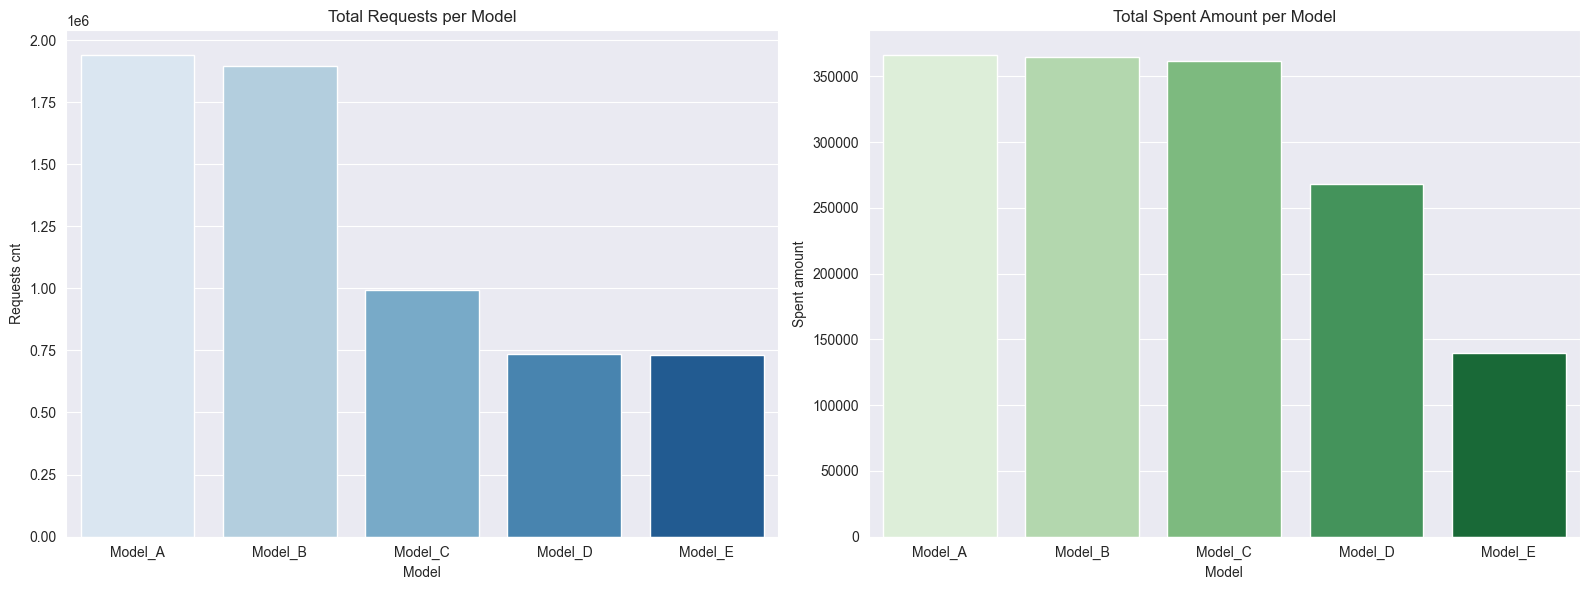

In [332]:
model_sum = df.groupby('model', observed=True)[['requests_cnt', 'spent_amount']].sum()

plot_summary_dual(
    model_sum,
    metrics=['requests_cnt', 'spent_amount'],
    titles=['Total Requests per Model', 'Total Spent Amount per Model'],
    palettes=['Blues', 'Greens']
)


The bar charts show the total number of requests generated and amount of units spent for each model across the entire dataset.

**Total Requests per Model**

- **Model_A** and **Model_B** have the highest request volumes, showing that they dominate usage among all models. There is a sharp drop after **Model_B**.
This steep decline indicates that while **Model_C** is still used, it is significantly less central to user activity compared with the top two models. **Model_D** **Model_E** both have the lowest request volume overall.

Overall, this distribution suggests that usage is not evenly distributed across models. A small number of models account for most of the activity, while others contribute only a minor share.

**Total Spent Amount per Model**

- **Model_A**, **Model_B** and **Model_C** show the highest overall spending levels (exceeding 350,000 in total amount), indicating that these three models have the highest usage and contribute most to user costs. In comparison, **Model_D** shows a drop in total spending, while **Model_E** has the lowest total spent amount among all models.


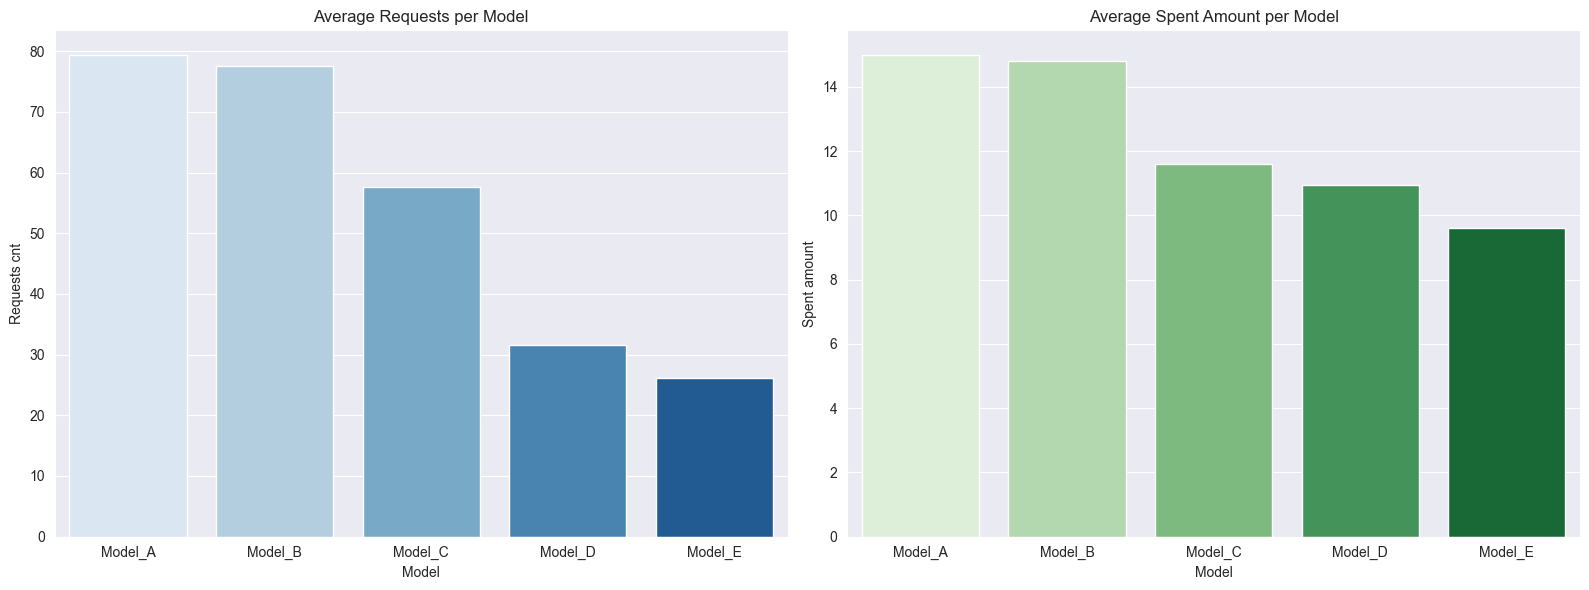

In [333]:
model_avg = df.groupby('model', observed=True)[['requests_cnt', 'spent_amount']].mean()

plot_summary_dual(
    model_avg,
    metrics=['requests_cnt', 'spent_amount'],
    titles=['Average Requests per Model', 'Average Spent Amount per Model'],
    palettes=['Blues', 'Greens']
)

**Average Requests per Model**

- **Model_A** has the highest average number of requests, followed closely by **Model_B** with slightly fewer requests
- **Model_C** shows a moderate level of activity
- **Model_D** has noticeably lower average activity, while **Model_E** records the lowest average

Overall, the average requests per model follow a similar pattern to total requests.

**Average Spent Amount per Model**

- **Model_A** and **Model_B** lead in average spending, indicating that users of these models consistently generate the highest costs per day/user
- **Model_C**, **Model_D**, and **Model_E** show moderate to lower average spending, with **Model_E** recording the lowest value

This difference highlights that while **Model_C** has high total spending due to many users, the average spent amount is moderate, showing that individual usage intensity is lower than for **Models A and B**.



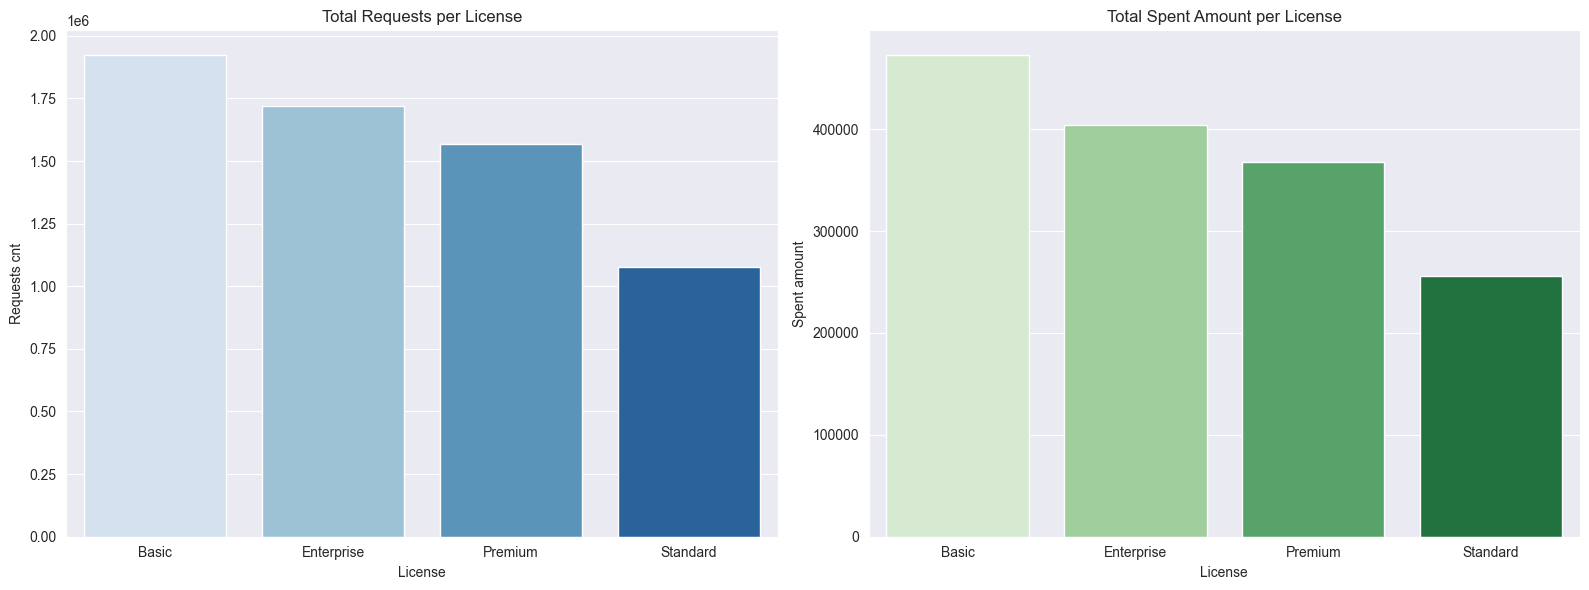

In [334]:
license_sum = df.groupby('license', observed=True)[['requests_cnt', 'spent_amount']].sum()

plot_summary_dual(
    license_sum,
    metrics=['requests_cnt', 'spent_amount'],
    titles=['Total Requests per License', 'Total Spent Amount per License'],
    palettes=['Blues', 'Greens']
)

**Total Requests and Total Spent Amount per License**

Both the total requests and total spent amount distributions show a very similar pattern across license types:
**Basic** > **Enterprise** > **Premium** > **Standard**

This order highlights a strong pattern in user behaviour:
- **Basic** license users have the highest request volume and total spending, indicating that this type has the largest and most active user base
- **Enterprise** license users also show high activity and spending, slightly below Basic
- **Premium** users follow with moderately high usage
- **Standart** users show the lowest request volume and total spending (roughly half of **Basic**), suggesting that **Standard** is the smallest or least active group of users

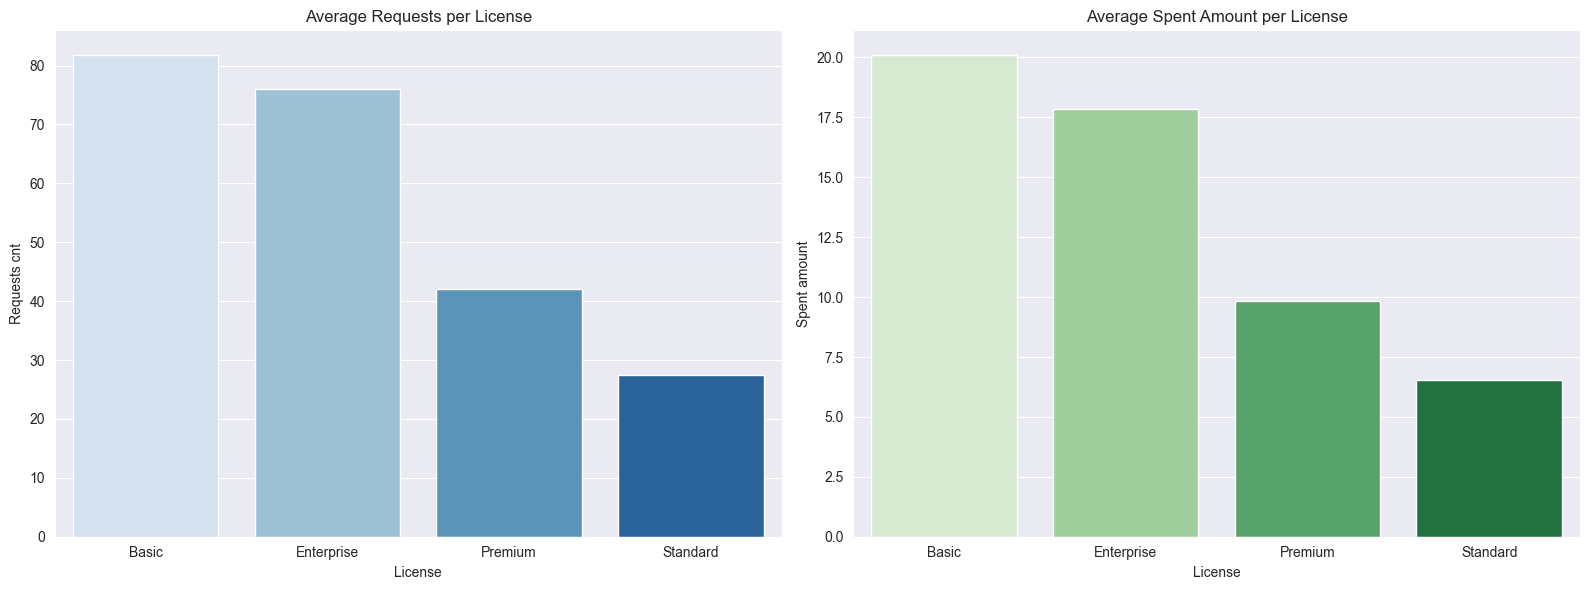

In [335]:
license_avg = df.groupby('license', observed=True)[['requests_cnt', 'spent_amount']].mean()

plot_summary_dual(
    license_avg,
    metrics=['requests_cnt', 'spent_amount'],
    titles=['Average Requests per License', 'Average Spent Amount per License'],
    palettes=['Blues', 'Greens']
)

**Average Requests and Average Spent Amount per License**

When examining totals, **Premium** still showed relatively high usage, and **Standard** was moderate.

   - **Basic** has the highest average requests and spending.
   - **Enterprise** comes next, slightly lower than Basic.
   - **Premium** now sits at a moderate level.
   - **Standard** records the lowest averages for both requests and spent amount.

This indicates that while total activity may be influenced by the number of users in each license category, the average requests and spent amount provide a slightly clearer view of individual usage intensity. It shows that Basic and Enterprise users are the most active, whereas Standard users engage less with the IDE features on average.


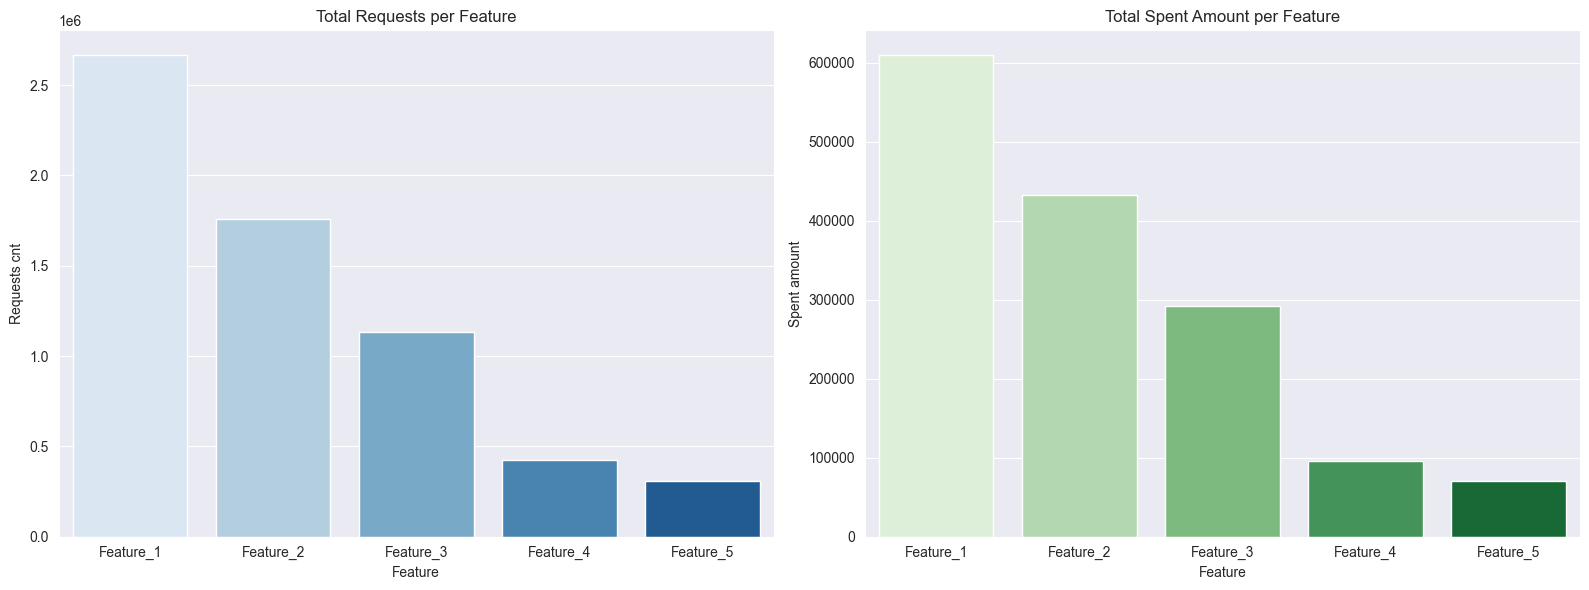

In [336]:
feature_sum = df.groupby('feature', observed=True)[['requests_cnt', 'spent_amount']].sum()

plot_summary_dual(
    feature_sum,
    metrics=['requests_cnt', 'spent_amount'],
    titles=['Total Requests per Feature', 'Total Spent Amount per Feature'],
    palettes=['Blues', 'Greens']
)

**Total Requests and Total Spent Amount per Feature**

The distribution of total requests and spending across features shows a clear descending pattern: **Feature_1** > **Feature_2** > **Feature_3** > **Feature_4** > **Feature_5**, with a significant drop from the top feature to the bottom.

These distributions suggest:
- **Feature_1** has the highest total requests, making it the most frequently used functionality in the IDE
- **Feature_2** and **Feature_3** follow with substantial usage, but clearly lower than Feature_1
- **Feature_4** and **Feature_5** have the lowest activity, indicating that they are used less frequently

The total spent amount mirrors this pattern, showing that higher usage features also contribute more to overall spending. The steep drop from **Feature_1** to **Feature_5** highlights that a small number of features dominate total usage and cost.

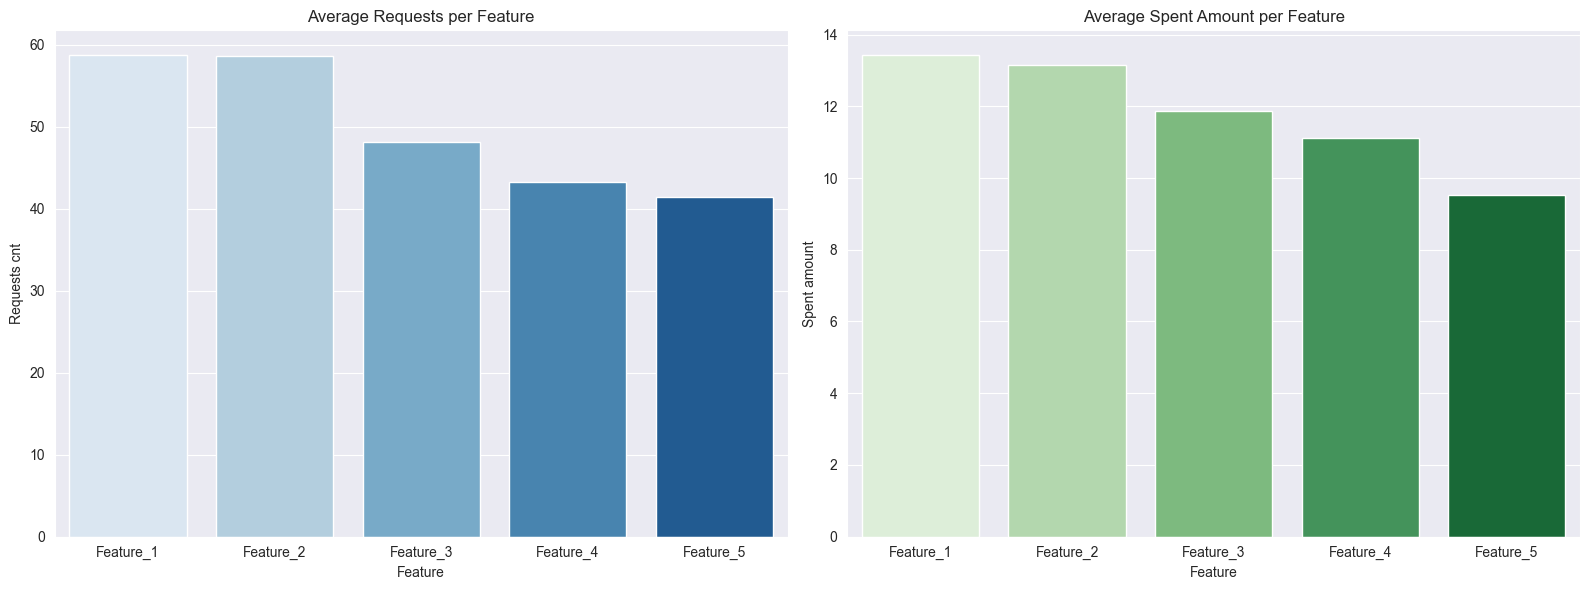

In [337]:
feature_avg = df.groupby('feature', observed=True)[['requests_cnt', 'spent_amount']].mean()

plot_summary_dual(
    feature_avg,
    metrics=['requests_cnt', 'spent_amount'],
    titles=['Average Requests per Feature', 'Average Spent Amount per Feature'],
    palettes=['Blues', 'Greens']
)

**Average Requests and Average Spent Amount per Feature**

When looking at average requests and spent amount, the differences between features are less pronounced, and all features show high usage.

- **Feature_1** still leads in average requests and spending, but the gap between features is smaller
- **Feature_2** follows closely, indicating strong engagement across these functionalities
- **Feature_3**, **Feature_4** and **Feature_5** now show high averages rather than being minimal, suggesting that while they are less dominant in totals, they are still actively used by individual users

This demonstrates that while total usage highlights dominance by a few features, average usage reveals that all features are meaningfully engaged with, providing a fuller picture of feature utilization across the user base.


### Proportion-based Analysis

In [338]:
def plot_pie(df_par, group_col, metric, title, ax=None, colors=None):
    summary = df_par.groupby(group_col, observed=True)[metric].sum()

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.pie(
        summary,
        labels=summary.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        counterclock=False
    )
    ax.set_title(title)


def plot_pie_dual(
    df_par,
    category_col,
    metric1='requests_cnt',
    metric2='spent_amount',
    colors1=None,
    colors2=None,
    title1=None,
    title2=None
):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # First metric
    plot_pie(df_par=df_par, group_col=category_col, metric=metric1,
             title=title1 or f'{metric1.replace("_", " ").title()} by {category_col.title()}',
             ax=axes[0], colors=colors1
             )

    # Second metric
    plot_pie(df_par=df_par, group_col=category_col, metric=metric2,
             title=title2 or f'{metric2.replace("_", " ").title()} by {category_col.title()}',
             ax=axes[1], colors=colors2
             )

    plt.tight_layout()
    plt.show()


For proportion-based analysis, we implemented the `plot_pie()` function to visualize the share of requests or spending for each category. To compare two metrics simultaneously, the `plot_pie_dual()` function was created.

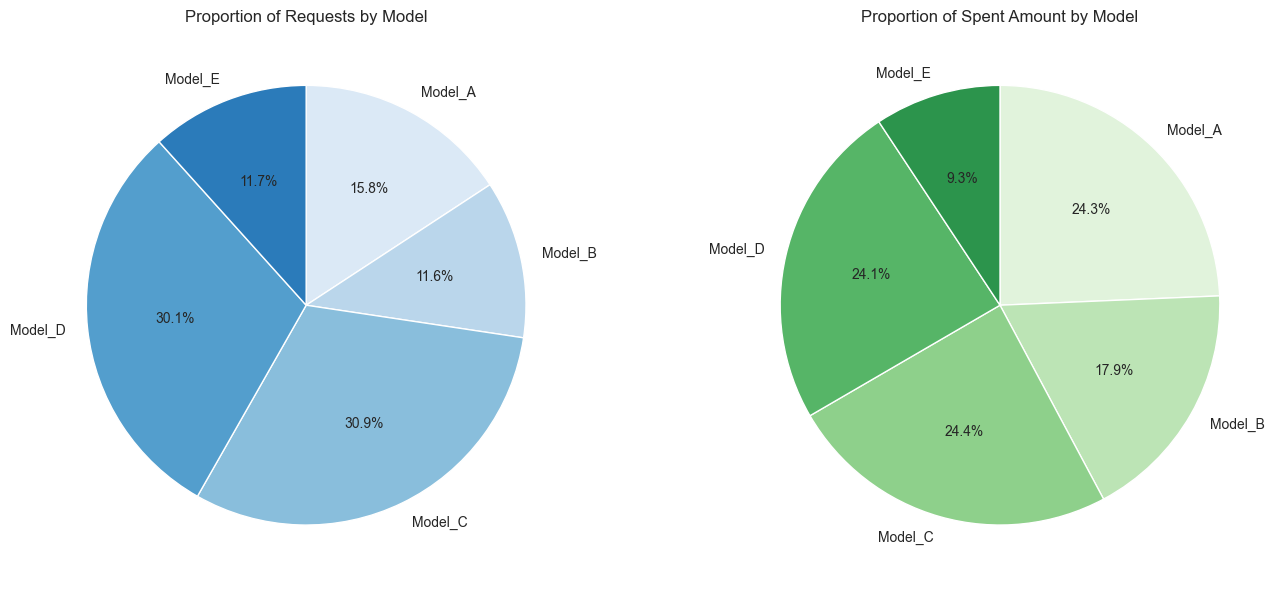

In [339]:
plot_pie_dual(df, 'model',
              colors1=sns.color_palette('Blues'), colors2=sns.color_palette('Greens'),
              title1='Proportion of Requests by Model', title2='Proportion of Spent Amount by Model'
              )

**Proportion of Requests and Spent Amount by Model**

The dual pie charts highlight the relative contribution of each model to overall activity and spending:

**Requests**:

- **Model_C** (30.9%) and **Model_D** (30.1%) together account for over 60% of all requests, showing that user activity is concentrated on these two models.
- **Model_A** (15.8%) and **Model_B** (11.6%) are moderately used, while **Model_E** (11.7%) has the lowest activity.

**Spent Amount**:

- **Model_A**, **Model_C**, and **Model_D** dominate spending with 24.3%, 24.4% and 24.1% accordingly, reflecting that these models not only receive many requests but also incur significant costs.
- **Model_B** contributes 17.9% of total spending, slightly below its request share, suggesting slightly lower costs
- **Model_E** has the smallest share of spending (9.3%), confirming its minor role in both activity and cost

**Insights**:

- Activity and spending are not evenly distributed across models
- A small set of models drives most usage and costs.
- There are minor discrepancies between request percentages and spending percentages for some models.

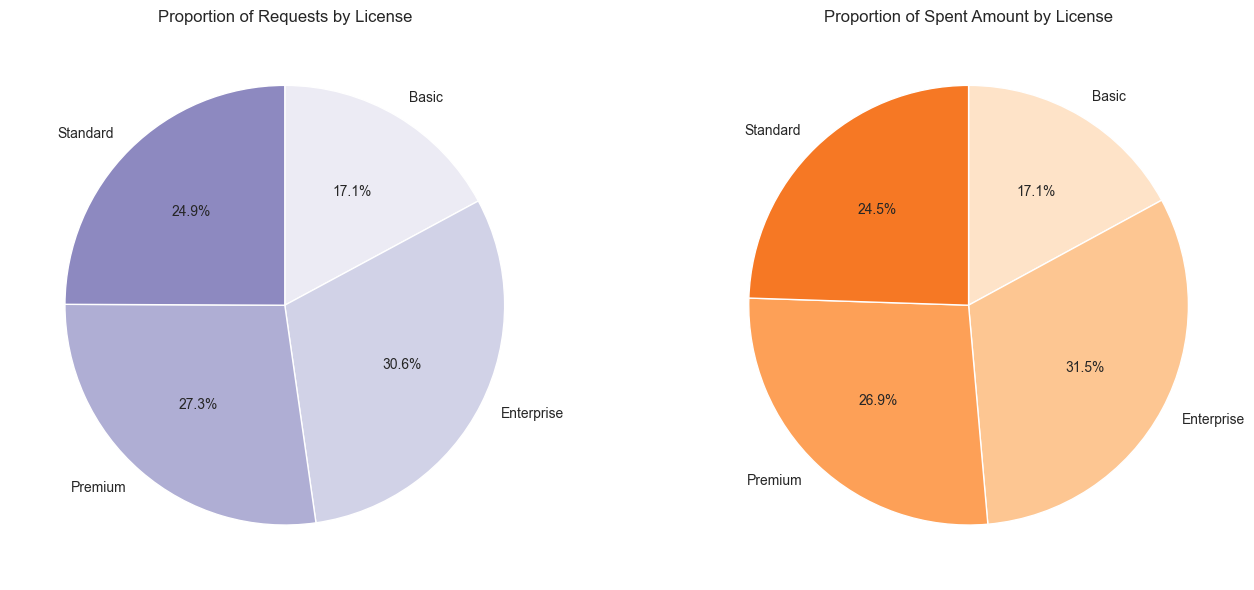

In [340]:
plot_pie_dual(df, 'license',
              colors1=sns.color_palette('Purples'), colors2=sns.color_palette('Oranges'),
              title1='Proportion of Requests by License', title2='Proportion of Spent Amount by License'
              )

**Proportion of Requests and Spent Amount by License**

The dual pie charts reveal how different license types contribute to overall activity and spending:

**Requests**:

- **Enterprise** (30.6%) and **Premium** (27.3%) together make up over half of total requests, highlighting that higher-tier licenses are responsible for most user activity
- **Standard** (24.9%) and **Basic** (17.1%) have smaller shares of requests

**Spent Amount**:

- **Enterprise** (31.5%) and **Premium** (26.9%) remain the top contributors to spending, mirroring the request distribution
- **Standard** (24.5%) and **Basic** (17.1%) have lower spending, consistent with their smaller activity share

**Insights**:

- Requests and spending are strongly correlated across licenses
- Higher-tier licenses drive the majority of usage and costs

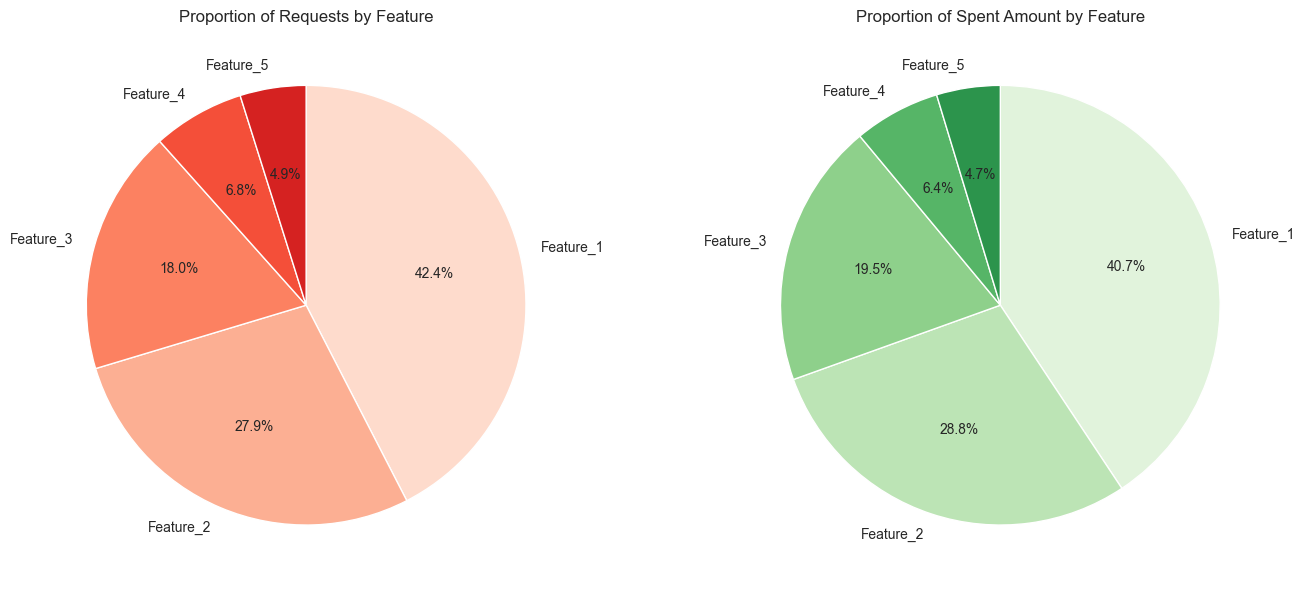

In [341]:
plot_pie_dual(df, 'feature',
              colors1=sns.color_palette('Reds'), colors2=sns.color_palette('Greens'),
              title1='Proportion of Requests by Feature', title2='Proportion of Spent Amount by Feature'
)

**Proportion of Requests and Spent Amount by Feature**

The dual pie charts highlight how different IDE features contribute to total usage and spending:

**Requests**:

- **Feature_1** dominates activity with 42.4% of total requests, making it the most central functionality in the IDE
- **Feature_2** (27.9%) and **Feature_3** (18.0%) follow, showing substantial but noticeably lower usage than **Feature_1
- **Feature_4** (6.8%) and **Feature_5** (4.9%) have minimal usage, indicating these features are less central

**Spent Amount**:

- **Feature_1** accounts for 40.7% of total spending, reflecting its high usage
- **Feature_2** (28.8%) and **Feature_3** (19.5%) again follow the same order as requests
- **Feature_4** (6.4%) and **Feature_5** (4.7%) remain minor contributors to spending

**Insights**:

- Both requests and spending distributions show that a few features dominate overall activity, while the rest contribute relatively little
- **Feature_1** clearly drives the majority of user engagement and cost, but **Feature_2** and **Feature_3** also represent meaningful usage

### Investigate the relationship between `requests_cnt` (user activity) and `spent_amount` (user spending)

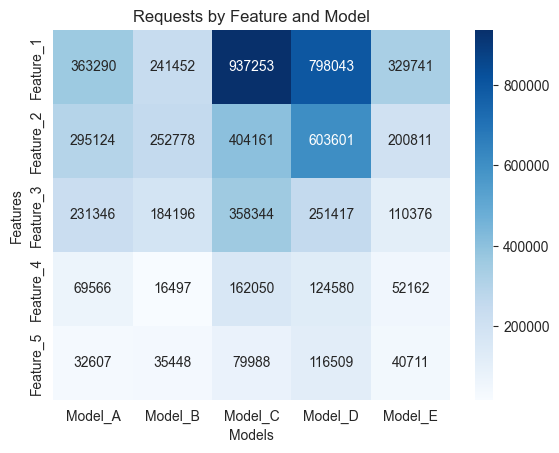

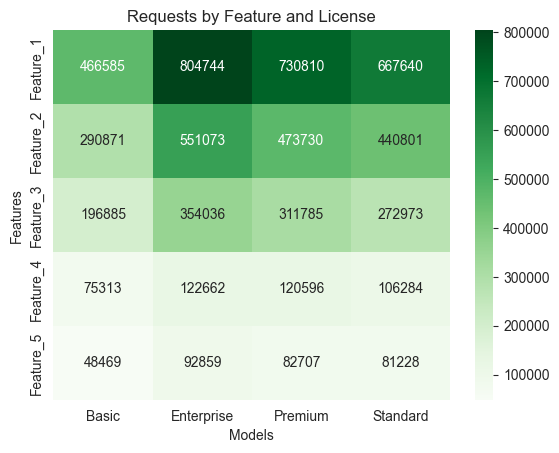

In [342]:
# Feature vs Model heatmap
pivot_feature_model = df.pivot_table(index='feature', columns='model', values='requests_cnt', aggfunc='sum', observed=True)
sns.heatmap(pivot_feature_model, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel('Models')
plt.ylabel('Features')
plt.title('Requests by Feature and Model')
plt.show()



# Feature vs License heatmap
pivot_feature_license = df.pivot_table(index='feature', columns='license', values='requests_cnt', aggfunc='sum', observed=True)
sns.heatmap(pivot_feature_license, annot=True, fmt=".0f", cmap="Greens")
plt.xlabel('Models')
plt.ylabel('Features')
plt.title('Requests by Feature and License')
plt.show()


After creating a heatmap for Feature-Model and Feature-License requests, we have observed the following patterns:

1. **Feature usage by model:**
   - **Feature_1** is used most with **Model_C** (937,253 requests), followed by **Model_D** (798,043)
   - **Feature_2** has a reversed pattern: highest usage is in **Model_D** (603,601), then **Model_C** (404,161)
   - **Feature_3** usage is also highest in **Model_C** (358,344), followed by **Model_D** (251,417)
   - **Feature_4** is repeating the same pattern: **Model_C** > **Model_D**
   - **Feature_5** is used most with **Model D**, being the only feature with more than 100,000 requests

   **Insights:**
   - Certain features are commonly used with specific models (e.g. **Feature_1** with both **Model_C** and **Model_D**)
   - **Model_C** is the most heavily used across multiple features (except **Feature_5**), while **Model_B** generally has lower usage

2. **Feature usage by license:**
    - **Feature_1** is most used by **Enterprise** users (804,744 requests), followed by **Premium** (730,810) and **Standard** (667,640). Basic license holders use it the least (466,585)
   - **Feature_2** follows the same pattern: **Enterprise** (551,073) > **Premium** (473,730) > **Standard** (440,801) > **Basic** (290,871)
   - **Feature_3** is also mostly used by Enterprise users (354,036), with decreasing usage for Premium, Standard, and Basic
   - **Features_4** and **Feature_5** have much lower usage overall, but **Enterprise** users show slightly higher usage than other license holders

   **Insights:**
   - Enterprise and Premium users are the most active across almost all features, suggesting that higher-tier licenses drive more feature usage
   - Basic users consistently have the lowest usage, showing either limited access to features or smaller engagement
   - Feature popularity is consistent across licenses: **Feature_1** and **Feature_2** are the most used, **Feature_3** is being right in the middle, while **Feature_4** and **Feature_5** are the least popular


### Aggregate data at daily, weekly, or monthly levels to analyze trends over time and provide different perspectives

To better understand user engagement dynamics, the dataset was analyzed at multiple time aggregations: daily and weekly. Considering that the dataset covers only 3 months (March-May) monthly aggregation has been proved unnecessary due to the lack of analytical value.

In [343]:
daily_summary = df.groupby('day_id')[['requests_cnt', 'spent_amount']].sum().reset_index()

fig = px.line(daily_summary,
              x='day_id',
              y='requests_cnt',
              title='Daily Requests Over Time (Interactive)',
              labels={'day_id': 'Date', 'requests_cnt': 'Total Requests'})
fig.update_traces(line=dict(color='royalblue', width=3))
fig.show()

fig = px.line(daily_summary,
              x='day_id',
              y='spent_amount',
              title='Daily Spending Over Time (Interactive)',
              labels={'day_id': 'Date', 'spent_amount': 'Total Spending'})
fig.update_traces(line=dict(color='seagreen', width=3))
fig.show()


The daily data shows significant volatility, with sharp spikes and drops in both `requests_cnt` and `spent_amount`.
Most of these fluctuations correspond to workdays/weekend cycles, with weekends showing consistently lower usage.
This confirms that users predominantly engage with models and features during workdays

In [344]:
daily_summary['is_weekend'] = daily_summary['day_id'].dt.weekday >= 5  # 5=Saturday, 6=Sunday

daily_summary.groupby('is_weekend')[['requests_cnt','spent_amount']].mean()

,requests_cnt,spent_amount
is_weekend,,
False,86994.861538,20768.920308
True,23606.851852,5590.130370


To verify observed usage patterns, we have compared average daily requests and spending on weekdays versus weekends:

- **Weekdays:** ~86995 requests and ~20769 credits spent
- **Weekends:** ~23607 requests and ~5590 credits spent

Weekday activity is roughly 3–4 times higher than weekend activity, confirming that users mostly engage with ML features during work hours.
Weekend usage remains noticeable but is significantly lower, suggesting professional usage drives most of the interaction and credit consumption.


#### Investigate the relationship between `requests_cnt` (user activity) and `spent_amount` (user spending).

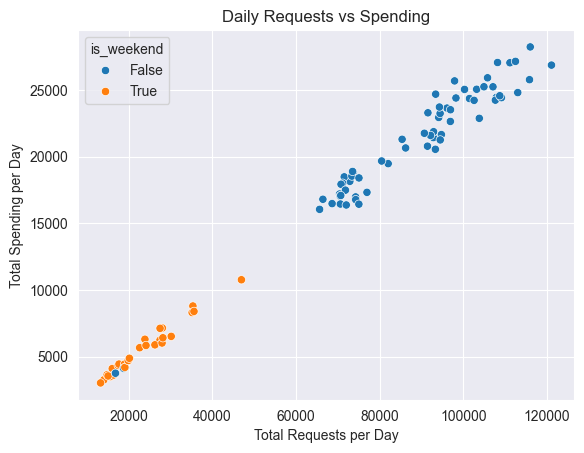


Correlation between requests and spending: 0.994


In [345]:
sns.scatterplot(data=daily_summary, x='requests_cnt', y='spent_amount', hue='is_weekend')
plt.xlabel('Total Requests per Day')
plt.ylabel('Total Spending per Day')
plt.title('Daily Requests vs Spending')
plt.show()

corr = daily_summary[['requests_cnt', 'spent_amount']].corr().iloc[0,1]
print(f"\nCorrelation between requests and spending: {corr:.3f}")

The scatter plot shows a very strong positive relationship between daily requests and spent amount.
The correlation between requests and spending is very high (**r = 0.994**), indicating a nearly perfect positive relationship: more activity corresponds to higher spending.
This suggests that active users are also the primary contributors to credit usage, highlighting a strong link between engagement and spending.

Notably, **Between March 31 and April 4**, there is a noticeable drop in both `requests_cnt` and `spent_amount`, even though this period falls on weekdays. This anomaly is evident in the scatter plot as several low blue dots, representing days when activity and spending were significantly below typical weekday levels.
Despite this short-term dip, overall weekly trends quickly rebound, showing that the drop is an isolated event rather than a persistent decline in engagement.

In [346]:
weekly_summary = df.resample('W', on='day_id')[['requests_cnt', 'spent_amount']].sum().reset_index()

fig = px.line(weekly_summary, x='day_id', y='requests_cnt',
              title='Weekly Requests Over Time (Interactive)',
              labels={'day_id': 'Date', 'requests_cnt': 'Total Requests'})
fig.update_traces(line=dict(color='royalblue', width=3))
fig.show()

fig = px.line(weekly_summary, x='day_id', y='spent_amount',
              title='Weekly Spending Over Time (Interactive)',
              labels={'day_id': 'Date', 'spent_amount': 'Total Spending'})
fig.update_traces(line=dict(color='seagreen', width=3))
fig.show()

corr = weekly_summary[['requests_cnt', 'spent_amount']].corr().iloc[0,1]
print(f"\nCorrelation between requests and spending: {corr:.3f}")


Correlation between requests and spending: 0.992


Weekly aggregation smooths daily charts and highlights a clear overall pattern.
User activity and spending steadily increase over time, indicating growing engagement with IDE ML features.
A short-term dip occurs at the beginning of April, followed by a stronger rebound that surpasses prior levels, suggesting renewed engagement.

The correlation between weekly requests and spending is **r = 0.992**, confirming once again that higher user activity closely corresponds to higher credit consumption.


### Summary

**Key Findings**

**Models**:

- **Model_A**, **Model_C** and **Model_D** lead in spending, while **Model_E** contributes the least
- Average requests and spending show that **Model_A** and **Model_B** users are the most initiative
- **Model_C** and **Model_D** dominate in request activity, accounting for over 60% of total requests together

**Licenses**:

- **Enterprise** and **Premium** license holders are responsible for the majority of requests and spending
- **Basic** users have high activity but lower averages, whereas **Standard** users are the least active
- Normalized usage confirms that **Enterprise** and **Premium** license holders are the most active

**Features**:

- **Feature_1** dominates both total and proportional usages (~42% of requests, ~41% of spending)
- **Feature_2** and **Feature_3** also show significant engagement of users, while **Feature_4** and **Feature_5** have minimal absolute usage.
- Average usage shows that all features are being used meaningfully, indicating no feature is entirely ignored

**Proportion-based Analysis**

- Pie charts show uneven distribution of requests and spending, highlighting that a few models, licenses and features drive the majority of activity
- Major discrepancies exist between request percentages and spending percentages, indicating differences in cost across models

**Temporal Patterns**:

- Daily user activity is highly volatile, with clear weekday/weekend patterns. Weekdays show 3-4 times higher usage than weekends
- Between March 31 and April 4, an unexpected drop occurred during the workweek, visible in both daily charts and the scatterplot
- Weekly trends indicate steady growth and high correlation between requests and spending

**Insights**:

- High-tear license users are the most active: **Enterprise** and **Premium** users are both frequent and high-spending
- All features are relevant: even less-used features have meaningful user engagement, which could justify maintaining or enhancing them
- User behavior is concentrated: a small subset of models, licenses and features drive the majority of requests and credit spending
- Requests and spending are tightly linked: engagement of users and credit spending are strongly correlated, indicating that any change in usage patterns directly affects spending

**Actionable Recommendations**:

- Monitor anomalies: investigate unusual dips (such as the March 31 - April 4 period) to identify any potential issues
- Optimize model usage: prioritize performance improvements, updates and support for the most popular models
- Prioritize features: maintain and enhance frequently used features, while considering improvements for less-used ones to ensure overall user satisfaction
- Plan capacity effectively: given the strong correlation between requests and spending, ensure that infrastructure scales appropriately with user growth
- Increase engagement of low-tier license users: implement initiatives to boost **Standard** and **Basic** license activity through promotions, feature highlights or targeted onboarding